In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tf.__version__

'2.17.0'

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

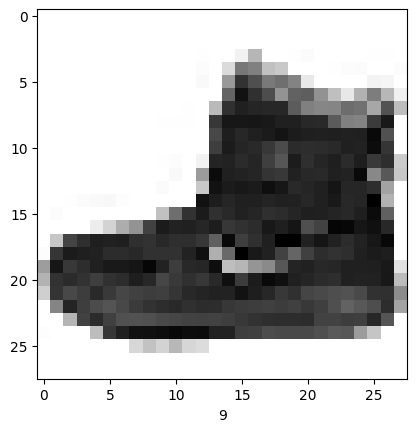

In [ ]:
plt.imshow(x_train[0],cmap='binary')
plt.xlabel(y_train[0])
plt.show()

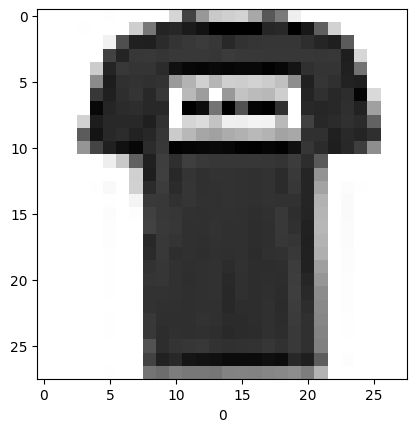

In [ ]:
plt.imshow(x_train[1],cmap='binary')
plt.xlabel(y_train[1])
plt.show()

In [ ]:
def create_model(hp):

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:             # if hp exists
    num_hidden_layers = hp.Choice('num_hidden_layers',values=[1,2,3])
    num_units = hp.Choice('num_units',values = [8,16,32])
    dropout_rate = hp.Float('dropout_rate',min_value=0.1,max_value=0.5)
    learning_rate = hp.Float('learning_rate',min_value=0.0001,max_value=0.01)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for layer in range(0,num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units,activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10,activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model




In [ ]:
create_model(None).summary()     # if we dont want hp to exists than use None as param for function

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    results = super(CustomTuner, self).run_trial(trial, *args, **kwargs)
    return results

In [ ]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [ ]:
tuner.search(x_train,y_train,
             validation_data=(x_test,y_test),
             epochs=5,
             verbose=True)

Trial 20 Complete [00h 00m 38s]
val_accuracy: 0.8256999850273132

Best val_accuracy So Far: 0.8567000031471252
Total elapsed time: 00h 09m 23s


In [ ]:
 model = tuner.get_best_models(num_models=1)[0]
 model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
aman = model.fit(x_train, y_train,
             epochs=20,
             validation_data=(x_test, y_test),
             batch_size = 128,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8502 - loss: 0.4074 - val_accuracy: 0.8585 - val_loss: 0.3981
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8546 - loss: 0.3957 - val_accuracy: 0.8548 - val_loss: 0.3985
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8584 - loss: 0.3926 - val_accuracy: 0.8611 - val_loss: 0.3966
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8614 - loss: 0.3802 - val_accuracy: 0.8553 - val_loss: 0.3912
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8596 - loss: 0.3866 - val_accuracy: 0.8587 - val_loss: 0.3920
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8628 - loss: 0.3738 - val_accuracy: 0.8573 - val_loss: 0.3960
